In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

# Read in data and do basic massaging

In [2]:
df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,...,82,114,147,177,212,272,322,411,599,599.0
1,NaN,Japan,36.0,138.0,2,1,2,2,4,4,...,773,839,825,878,889,924,963,1007,1086,1086.0


In [3]:
df_raw['Country/Region'].unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'San Marino', 'Belarus', 'Iceland', 'Lithuania',
       'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile',
       'Jordan', 'Ukraine', 'Hungary', 'Liechtenstein', 'Poland',
       'Tunisia', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa',
       'Bhutan', 'Cameroon', 'Colombia', 'Costa R

In [4]:
df = df_raw.drop(['Lat', 'Long'], axis=1)                   # drop the Lat/Lon columns
df = df.set_index(['Country/Region', 'Province/State'])     # set index (for rows) to country + state
df = df.stack().unstack(level=[0,1])                        # rotate so country+state is across top and dates go down
df.head(2)

Country/Region Thailand Japan Singapore Nepal Malaysia           Canada  \
Province/State      NaN   NaN       NaN   NaN      NaN British Columbia   
1/22/20             2.0   2.0       0.0   0.0      0.0              0.0   
1/23/20             3.0   1.0       1.0   0.0      0.0              0.0   

Country/Region       Australia                     Cambodia  ...  \
Province/State New South Wales Victoria Queensland      NaN  ...   
1/22/20                    0.0      0.0        0.0      0.0  ...   
1/23/20                    0.0      0.0        0.0      0.0  ...   

Country/Region                           US      Greenland Guam Guernsey  \
Province/State United States Virgin Islands   US       NaN  NaN      NaN   
1/22/20                                 0.0  0.0       0.0  0.0      0.0   
1/23/20                                 0.0  0.0       0.0  0.0      0.0   

Country/Region Jersey Puerto Rico Republic of the Congo The Bahamas The Gambia  
Province/State    NaN         NaN                   NaN         NaN        NaN  
1/22/20           0.0         0.0                   0.0         0.0        0.0  
1/23/20           0.0         0.0                   0.0         0.0        0.0  

[2 rows x 501 columns]

# Fix the State datasets for CA, WA and NY
Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level. We need to create a merged California dataset with summation of counties before 3/10 and the 'Califorina' column from 3/10 onward

In [5]:
# Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level
idx =  pd.IndexSlice
df.loc['3/7/20':'3/12/20',idx[:,['California', 'Santa Clara County, CA', 'New York', 'Suffolk County, NY','Washington', 'King County, WA']]]

Country/Region         US                                         \
Province/State Washington New York California Suffolk County, NY   
3/7/20                0.0      0.0        0.0                0.0   
3/8/20                0.0      0.0        0.0                1.0   
3/9/20                0.0      0.0        0.0                1.0   
3/10/20             267.0    173.0      144.0                0.0   
3/11/20             366.0    220.0      177.0                0.0   
3/12/20             442.0    328.0      221.0                0.0   

Country/Region                                         
Province/State Santa Clara County, CA King County, WA  
3/7/20                           32.0            71.0  
3/8/20                           38.0            83.0  
3/9/20                           38.0            83.0  
3/10/20                           0.0             0.0  
3/11/20                           0.0             0.0  
3/12/20                           0.0             0.0

In [6]:
# Create a merged California dataset with summation of counties before 3/10 and the
# 'Califorina' column from 3/10 onward
cal_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", CA")] # get all index entries (counties) ending in ", CA"
cal_locations = list(cal_locations.values)
cal_locations.append('California')                                              # include the 'California' state column to the list
cal_merged = df.loc[:, idx[:, cal_locations]].sum(axis=1)                       # cal_merged is the new California dataset

ny_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", NY")] # get all index entries (counties) ending in ", NY"
ny_locations = list(ny_locations.values)
ny_locations.append('New York')                                              # include the 'New York' state column to the list
ny_merged = df.loc[:, idx[:, ny_locations]].sum(axis=1)                      

wa_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", WA")] # get all index entries (counties) ending in ", WA"
wa_locations = list(wa_locations.values)
wa_locations.append('Washington')                                              # include the 'Washington' state column to the list
wa_merged = df.loc[:, idx[:, wa_locations]].sum(axis=1)                      

cal_merged['3/7/20':'3/12/20']

3/7/20      81.0
3/8/20      95.0
3/9/20     101.0
3/10/20    144.0
3/11/20    177.0
3/12/20    221.0
dtype: float64

# Narrow down to a set of interesting countries plus California and graph

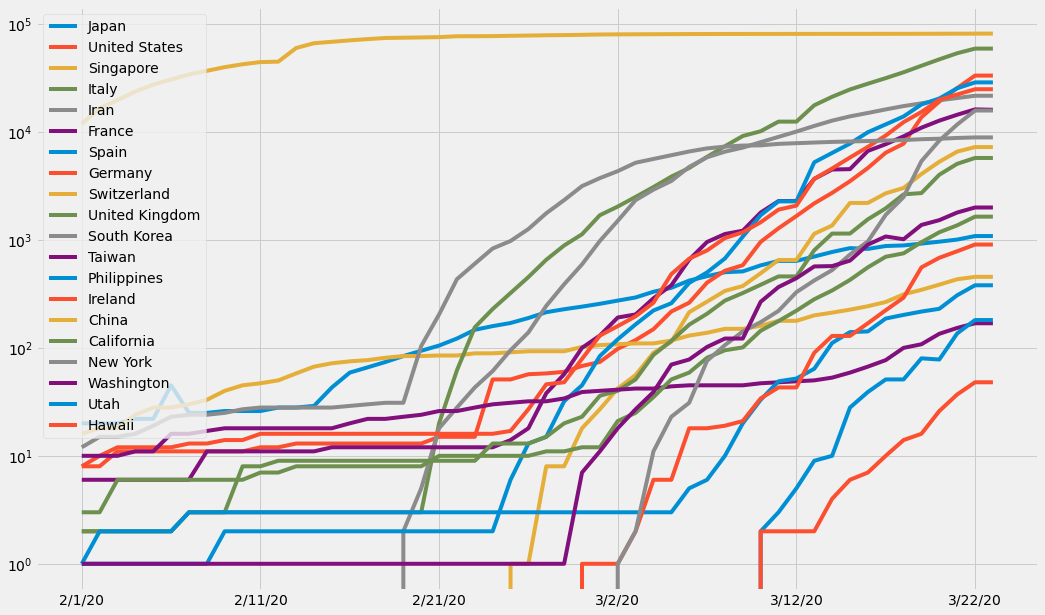

In [7]:
newdf = pd.DataFrame(index = df.index,
                     data = {
                         'Japan': df.loc[:, idx['Japan',:]].sum(axis=1),
                         'United States': df.loc[:, idx['US',:]].sum(axis=1),
                         'Singapore': df.loc[:, idx['Singapore',:]].sum(axis=1),
                         'Italy': df.loc[:, idx['Italy',:]].sum(axis=1),
                         'Iran': df.loc[:, idx['Iran',:]].sum(axis=1),
                         'France': df.loc[:, idx['France',:]].sum(axis=1),
                         'Spain': df.loc[:, idx['Spain',:]].sum(axis=1),
                         'Germany': df.loc[:, idx['Germany',:]].sum(axis=1),
                         'Switzerland': df.loc[:, idx['Switzerland',:]].sum(axis=1),
                         'United Kingdom': df.loc[:, idx['United Kingdom',:]].sum(axis=1),
                         'South Korea': df.loc[:, idx['Korea, South',:]].sum(axis=1),
                         'Taiwan': df.loc[:, idx['Taiwan*',:]].sum(axis=1),
                         'Philippines': df.loc[:, idx['Philippines',:]].sum(axis=1),
                         'Ireland': df.loc[:, idx['Ireland',:]].sum(axis=1),
                         'China': df.loc[:, idx['China',:]].sum(axis=1),
                         'California': cal_merged,
                         'New York': ny_merged,
                         'Washington': wa_merged,
                         'Utah': df.loc[:, idx[:,'Utah']].sum(axis=1),
                         'Hawaii': df.loc[:, idx[:,'Hawaii']].sum(axis=1),
                     }

)
newdf.loc['2/1/20':,:].plot(logy=True)

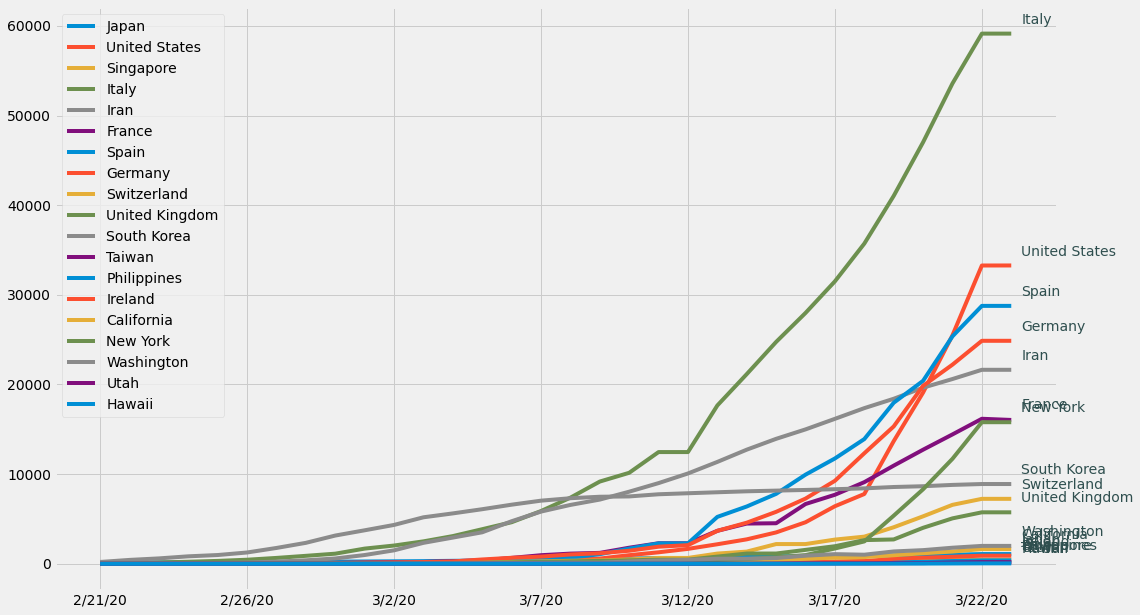

In [28]:
def label_lines(df, ax):
    for label in df.columns:
        previous = df.index[0]
        for xdays, datapoint in enumerate(df[label]):
            if pd.isnull(datapoint) or (xdays == len(df[label])-1):
                ax.annotate(label, (xdays, previous), 
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')
                break
            else:
                previous = datapoint

graph_data = newdf.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot()
label_lines(graph_data, ax)
plt.show()

In [8]:
popdf = pd.DataFrame(index = df.index,
                     data = {
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Spain': 46754778,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'California': 39747267,
                         'New York': 19491339,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Washington': 7797095,
                         'China': 1439323776,
                     }

)
popdf

casesper100kdf = newdf.div(popdf).mul(100000)
casesper100kdf.loc['3/14/20':'3/15/20',:]

,California,China,France,Germany,Hawaii,Iran,Ireland,Italy,Japan,New York,Philippines,Singapore,South Korea,Spain,Switzerland,Taiwan,United Kingdom,United States,Utah,Washington
3/14/20,0.855405,5.626045,6.874151,5.472409,0.283148,15.154844,2.612507,34.992327,0.611181,2.693504,0.101295,3.623720,15.771657,13.669191,15.702592,0.222532,1.685178,0.823860,0.304682,7.336066
3/15/20,1.071772,5.627851,6.929304,6.916600,0.424723,16.594250,2.612507,40.929958,0.663365,3.755514,0.127759,3.863022,15.919894,16.678509,25.419943,0.247725,1.686651,1.057091,0.853108,8.246661


# Create a 'days since 100 cases' graph

In [9]:
newdf.head(2)

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China,California,New York,Washington,Utah,Hawaii
1/22/20,2,1,0,0,0,0,0,0,0,0,1,1,0,0,548,0,0,1,0,0
1/23/20,1,1,1,0,0,0,0,0,0,0,1,1,0,0,643,0,0,1,0,0


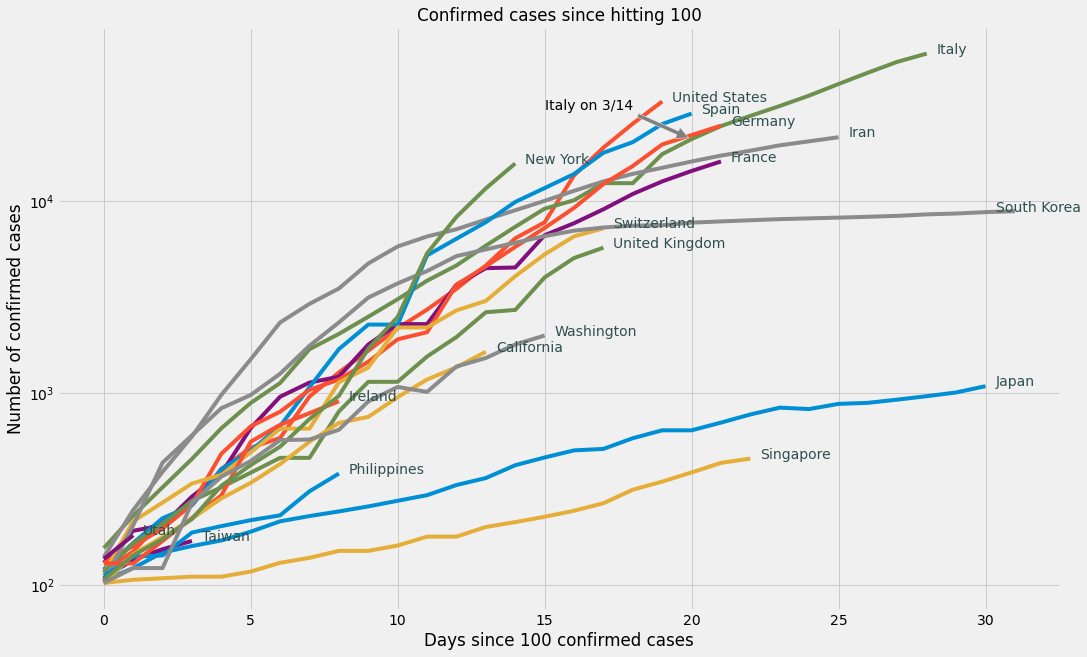

In [10]:
threshold = 100
daysSince100 = pd.DataFrame(index=range(0,len(newdf.index)))
for location in newdf.columns:
    # create list of data once above 'threshold'
    tempList = [newdf.loc[date, location] 
                              for date in newdf[location].index 
                              if newdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
            arrowprops=dict(facecolor='grey', shrink=0.05),)


for location in daysSince100.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSince100[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSince100[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
            
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
        

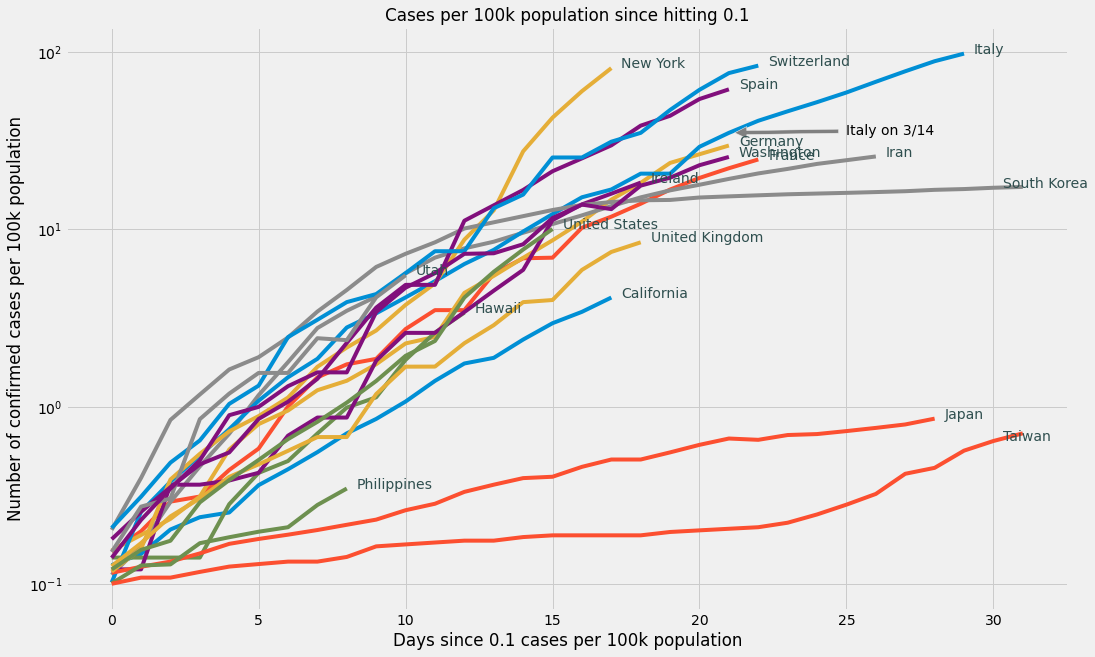

In [11]:
threshold = .1
daysSincerate = pd.DataFrame(index=range(0,len(casesper100kdf.index)))
for location in casesper100kdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesper100kdf.loc[date, location] 
                              for date in casesper100kdf[location].index 
                              if casesper100kdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


daysSincerate = daysSincerate.drop(['China', 'Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per 100k population since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since 0.1 cases per 100k population', fontsize='large')
ax.set_ylabel('Number of confirmed cases per 100k population', fontsize='large')
ax.annotate("Italy on 3/14", xy=(21,34.99), xytext=(25, 34),
            arrowprops=dict(facecolor='grey', shrink=0.05),)

for location in daysSincerate.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSincerate[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSincerate[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
plt.show()
        

In [12]:
daysSince100

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,California,New York,Washington,Utah
0,105.0,118.0,102.0,155.0,139.0,130.0,120.0,130.0,114.0,116.0,104.0,108.0,111.0,129.0,101.0,106.0,102.0,136.0
1,122.0,149.0,106.0,229.0,245.0,191.0,165.0,159.0,214.0,164.0,204.0,135.0,140.0,129.0,144.0,142.0,122.0,181.0
2,147.0,217.0,108.0,322.0,388.0,204.0,222.0,196.0,268.0,207.0,433.0,153.0,142.0,169.0,177.0,173.0,122.0,NaN
3,159.0,262.0,110.0,453.0,593.0,288.0,259.0,262.0,337.0,274.0,602.0,169.0,187.0,223.0,221.0,220.0,267.0,NaN
4,170.0,402.0,110.0,655.0,978.0,380.0,400.0,482.0,374.0,322.0,833.0,NaN,202.0,292.0,282.0,328.0,366.0,NaN
5,189.0,518.0,117.0,888.0,1501.0,656.0,500.0,670.0,491.0,384.0,977.0,NaN,217.0,557.0,340.0,421.0,442.0,NaN
6,214.0,583.0,130.0,1128.0,2336.0,957.0,673.0,799.0,652.0,459.0,1261.0,NaN,230.0,683.0,426.0,525.0,568.0,NaN
7,228.0,959.0,138.0,1694.0,2922.0,1134.0,1073.0,1040.0,652.0,459.0,1766.0,NaN,307.0,785.0,557.0,732.0,572.0,NaN
8,241.0,1281.0,150.0,2036.0,3513.0,1217.0,1695.0,1176.0,1139.0,802.0,2337.0,NaN,380.0,906.0,698.0,967.0,643.0,NaN
9,256.0,1663.0,150.0,2502.0,4747.0,1792.0,2277.0,1457.0,1359.0,1144.0,3150.0,NaN,NaN,NaN,751.0,1706.0,904.0,NaN


# Look at growth factor changes

In [13]:
start_date = '2/27/20'
window = 3
location = ['California', 'Italy']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
newdf.loc[start_date:,:]

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China,California,New York,Washington,Utah,Hawaii
2/27/20,214,58,93,655,245,38,15,46,8,15,1766,32,3,0,78600,11,0,1,0,0
2/28/20,228,60,93,888,388,57,32,48,8,20,2337,34,3,0,78928,11,0,1,0,0
2/29/20,241,68,102,1128,593,100,45,79,18,23,3150,39,3,1,79356,12,0,7,0,0
3/1/20,256,74,106,1694,978,130,84,130,27,36,3736,40,3,1,79932,12,0,11,0,0
3/2/20,274,98,108,2036,1501,191,120,159,42,40,4335,41,3,1,80136,21,1,18,0,0
3/3/20,293,118,110,2502,2336,204,165,196,56,51,5186,42,3,2,80261,25,2,27,0,0
3/4/20,331,149,110,3089,2922,288,222,262,90,86,5621,42,3,6,80386,35,11,39,0,0
3/5/20,360,217,117,3858,3513,380,259,482,114,116,6088,44,3,6,80537,51,23,70,0,0
3/6/20,420,262,130,4636,4747,656,400,670,214,164,6593,45,5,18,80690,59,31,78,0,0
3/7/20,461,402,138,5883,5823,957,500,799,268,207,7041,45,6,18,80770,81,76,102,0,0


In [14]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
newdf.loc[start_date:,:].diff().pct_change().add(1)

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China,California,New York,Washington,Utah,Hawaii
2/27/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/28/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/29/20,0.928571,4.000000,inf,1.030043,1.433566,2.263158,0.764706,15.500000,inf,0.600000,1.423818,2.500000,NaN,inf,1.304878,inf,NaN,inf,NaN,NaN
3/1/20,1.153846,0.750000,0.444444,2.358333,1.878049,0.697674,3.000000,1.645161,0.900000,4.333333,0.720787,0.200000,NaN,0.000000,1.345794,0.000000,NaN,0.666667,NaN,NaN
3/2/20,1.200000,4.000000,0.500000,0.604240,1.358442,2.033333,0.923077,0.568627,1.666667,0.307692,1.022184,1.000000,NaN,NaN,0.354167,inf,inf,1.750000,NaN,NaN
3/3/20,1.055556,0.833333,1.000000,1.362573,1.596558,0.213115,1.250000,1.275862,0.933333,2.750000,1.420701,1.000000,NaN,inf,0.612745,0.444444,1.000000,1.285714,NaN,NaN
3/4/20,2.000000,1.550000,0.000000,1.259657,0.701796,6.461538,1.266667,1.783784,2.428571,3.181818,0.511163,0.000000,NaN,4.000000,1.000000,2.500000,9.000000,1.333333,NaN,NaN
3/5/20,0.763158,2.193548,inf,1.310051,1.008532,1.095238,0.649123,3.333333,0.705882,0.857143,1.073563,inf,NaN,0.000000,1.208000,1.600000,1.333333,2.583333,NaN,NaN
3/6/20,2.068966,0.661765,1.857143,1.011704,2.087986,3.000000,3.810811,0.854545,4.166667,1.600000,1.081370,0.500000,inf,inf,1.013245,0.500000,0.666667,0.258065,NaN,NaN
3/7/20,0.683333,3.111111,0.615385,1.602828,0.871961,1.090580,0.709220,0.686170,0.540000,0.895833,0.887129,0.000000,0.500000,0.000000,0.522876,2.750000,5.625000,3.000000,NaN,NaN


In [15]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
tempdf = newdf.drop('3/12/20', axis='index')
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China,California,New York,Washington,Utah,Hawaii
2/27/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/28/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/29/20,0.928571,4.000000,inf,1.030043,1.433566,2.263158,0.764706,15.500000,inf,0.600000,1.423818,2.500000,NaN,inf,1.304878,inf,NaN,inf,NaN,NaN
3/1/20,1.153846,0.750000,0.444444,2.358333,1.878049,0.697674,3.000000,1.645161,0.900000,4.333333,0.720787,0.200000,NaN,0.000000,1.345794,0.000000,NaN,0.666667,NaN,NaN
3/2/20,1.200000,4.000000,0.500000,0.604240,1.358442,2.033333,0.923077,0.568627,1.666667,0.307692,1.022184,1.000000,NaN,NaN,0.354167,inf,inf,1.750000,NaN,NaN
3/3/20,1.055556,0.833333,1.000000,1.362573,1.596558,0.213115,1.250000,1.275862,0.933333,2.750000,1.420701,1.000000,NaN,inf,0.612745,0.444444,1.000000,1.285714,NaN,NaN
3/4/20,2.000000,1.550000,0.000000,1.259657,0.701796,6.461538,1.266667,1.783784,2.428571,3.181818,0.511163,0.000000,NaN,4.000000,1.000000,2.500000,9.000000,1.333333,NaN,NaN
3/5/20,0.763158,2.193548,inf,1.310051,1.008532,1.095238,0.649123,3.333333,0.705882,0.857143,1.073563,inf,NaN,0.000000,1.208000,1.600000,1.333333,2.583333,NaN,NaN
3/6/20,2.068966,0.661765,1.857143,1.011704,2.087986,3.000000,3.810811,0.854545,4.166667,1.600000,1.081370,0.500000,inf,inf,1.013245,0.500000,0.666667,0.258065,NaN,NaN
3/7/20,0.683333,3.111111,0.615385,1.602828,0.871961,1.090580,0.709220,0.686170,0.540000,0.895833,0.887129,0.000000,0.500000,0.000000,0.522876,2.750000,5.625000,3.000000,NaN,NaN


Text(0.5, 1.0, 'Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n(3 day moving average)')

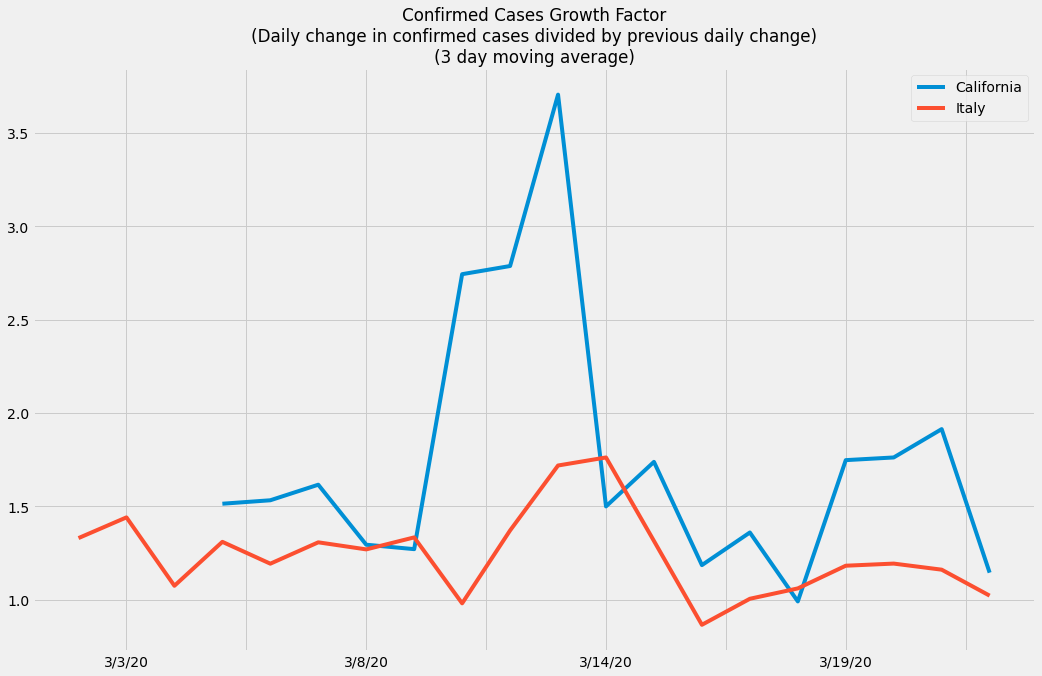

In [16]:
# graph the growth factors
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
#ax.set_ylim(ymin=0, ymax=4)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')